# ProteinSolver Demo

Here, we load the ProteinSolver network and use it to design sequences that match the geometry of the PDZ domain.

In [1]:
import os
import sys
from pathlib import Path
import tqdm
import torch
import torch_geometric
import matplotlib.pyplot as plt
import pandas as pd
import heapq
from IPython.display import display, HTML, Image

# Warning: proteinsolver is very buggy!
# You may need to edit files manually if you get any errors.
import proteinsolver
# Warning: kmbio is buggy too!
# Some of the imports need to be redirected to biopython
import Bio
from kmbio import PDB
from kmtools import sci_tools, structure_tools

# Add project root to path
module_path = os.path.abspath(os.path.join(os.pardir))
if module_path not in sys.path:
    sys.path.append(module_path)

from lib import viz
from lib.schema import Protein, ProteinSolverResult, Session
from lib.util import find_contacts

_ColormakerRegistry()

In [2]:
session = Session()
ids = [x[0] for x in session.query(Protein.pdb_id).all()]

In [3]:
#
# Globals
#

# PICK YOUR PROTEIN HERE!
PDB_ID = ids[55]

DATA_PATH = "/home/home3/fny/cs590/data/proteinsolver"
PDB_PATH = Bio.PDB.PDBList().retrieve_pdb_file(PDB_ID, file_format="pdb", pdir=DATA_PATH)
STRUCTURE = PDB.Structure(PDB_ID + "_A", PDB.load(PDB_PATH)[0].extract('A'))
MODEL_ID = "191f05de"
MODEL_STATE = "protein_train/191f05de/e53-s1952148-d93703104.state"

print('Protein ID:', PDB_ID)

Structure exists: '/home/home3/fny/cs590/data/proteinsolver/pdb3gnj.ent' 
Protein ID: 3GNJ


The following should return True indicating GPUs are available.

In [4]:
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
torch.cuda.is_available()

False

## Load Model

In [5]:
torch.cuda.empty_cache()

In [6]:
%run ../protein_train/{MODEL_ID}/model.py

In [7]:
# Model configuration
batch_size = 1
num_features = 20
adj_input_size = 2
hidden_size = 128
frac_present = 0.5
frac_present_valid = frac_present
info_size= 1024
state_file = MODEL_STATE

net = Net(
    x_input_size=num_features + 1, adj_input_size=adj_input_size, hidden_size=hidden_size, output_size=num_features
)
net.load_state_dict(torch.load('../' + state_file, map_location=device))
net.eval()
net = net.to(device)

## Data Preprocessing

Many proteins from the PDB did not work due to functional groups being placed at the residue locations. This portion of the script corrects for that.

In [8]:
from typing import NamedTuple

class ProteinData(NamedTuple):
    sequence: str
    row_index: torch.LongTensor
    col_index: torch.LongTensor
    distances: torch.FloatTensor

def extract_seq_and_adj(structure, chain_id):
    domain, result_df = get_interaction_dataset_wdistances(
        StructureWrapper(structure), 0, chain_id, r_cutoff=12
    )
    domain_sequence = structure_tools.get_chain_sequence(domain)
    assert max(result_df["residue_idx_1"].values) < len(domain_sequence)
    assert max(result_df["residue_idx_2"].values) < len(domain_sequence)
    
    data = ProteinData(
        domain_sequence,
        result_df["residue_idx_1"].values,
        result_df["residue_idx_2"].values,
        result_df["distance"].values
    )
    return data


def get_interaction_dataset_wdistances(
    structure, model_id, chain_id, r_cutoff=100
):
    chain = structure[0][chain_id]
    num_residues = len(list(chain.residues))
    dd = structure_tools.DomainDef(model_id, chain_id, 1, num_residues)
    domain = structure_tools.extract_domain(structure, [dd])
    distances_core = structure_tools.get_distances(
        domain.to_dataframe(), r_cutoff, groupby="residue"
    )
    assert (distances_core["residue_idx_1"] <= distances_core["residue_idx_2"]).all()
    return domain, distances_core


class StructureWrapper(object):
    def __init__(self, structure):
        self.structure = structure
    
    def __getitem__(self, item):
         return StructureWrapper(self.structure[item])

    def __getattr__(self, name):
        if name == 'residues':
            rs = []
            for residue in STRUCTURE.residues:
                x, _, _ = residue.id
                if x == ' ':
                    rs.append(residue)
            return rs
        return getattr(self.structure, name)

def preprocess(structure):
    return extract_seq_and_adj(StructureWrapper(STRUCTURE), 'A')

STRUCTURE_SUMMARY = preprocess(STRUCTURE)

## Searching for Designs

The model returns probabilities for every amino acid for each residue in the sequence. One method to search the space is using uniform cost search (i.e. single-source, greedy Djikstra's).

We start with the initial sequence and run it through the model. We then find the amino acid with the highest score for each residue, create a series of new chains with those residues updated, and place the newly created chains back in the prioirty queue which is ordered by score.

In [9]:
@torch.no_grad()
def frontier(net, x, x_score, edge_index, edge_attr, cutoff):
    index_array = torch.arange(len(x))
    mask = x == 20
    
    # Compute the output
    output = torch.softmax(net(x, edge_index, edge_attr), dim=1)[mask]
    # Select missing positions
    index_array = index_array[mask]
    
    # Find the entry with the highest probability
    max_score, max_index = output.max(dim=1)[0].max(dim=0)
    row_with_max_score = output[max_index]
    
    # Build nodes to search where each node updates one
    # probability from the maximum found
    nodes = []
    for i, p in enumerate(row_with_max_score):
        x_clone = x.clone()
        x_score_clone = x_score.clone()
        x_clone[index_array[max_index]] = i
        x_score_clone[index_array[max_index]] = torch.log(p)
        nodes.append((x_clone, x_score_clone))
    return nodes

@torch.no_grad()
def protein_search(net, x, edge_index, edge_attr, candidates, cutoff, max_iters = 1000000, verbose=False):
    x_score = torch.ones_like(x).to(torch.float) * cutoff
    heap = [(0, torch.randn(1), x, x_score)]
    
    iters = tqdm.tqdm(range(max_iters)) if verbose else range(max_iters)
    
    for i in iters:        
        p, tiebreaker, x, x_score = heapq.heappop(heap)        
        n_missing = torch.sum(x == 20)
        if verbose and i % 1000 == 0:
            print(i, p,
                "- Heap:", len(heap),
                f", Results:", len(candidates),
                f", Missing: {n_missing}/{x.shape[0]}"                
            )
        if n_missing == 0:
            candidates.append((p.cpu(), x.data.cpu().numpy(), x_score.data.cpu().numpy()))
            continue
        for x, x_score in frontier(net, x, x_score, edge_index, edge_attr, cutoff):
            pre_p = -x_score.sum()
            heapq.heappush(heap, (-x_score.sum(), torch.randn(1), x, x_score))
    return candidates

# Convert protein data and load it into the to GPU
row_data = proteinsolver.datasets.protein.row_to_data(STRUCTURE_SUMMARY)
data = proteinsolver.datasets.protein.transform_edge_attr(row_data)
data.to(device)
data.y = data.x

candidates = []
try:
    protein_search(net, torch.ones_like(data.x) * 20, data.edge_index, data.edge_attr, candidates=candidates, cutoff=np.log(0.15), verbose=True, max_iters=2000)
except KeyboardInterrupt:
    pass

  0%|          | 2/2000 [00:00<02:00, 16.61it/s]

0 0 - Heap: 0 , Results: 0 , Missing: 107/107


 50%|█████     | 1009/2000 [00:16<00:13, 70.85it/s]

1000 tensor(120.1166) - Heap: 5420 , Results: 679 , Missing: 0/107


100%|██████████| 2000/2000 [00:31<00:00, 64.48it/s] 


## Results

In [10]:
df = pd.DataFrame([
  (
      ''.join(proteinsolver.utils.AMINO_ACIDS[i] for i in candidate[1]),
      candidate[2].sum(),
      candidate[2].sum() / len(candidate[1]),
      float((candidate[1] == data.x.data.cpu().numpy()).sum().item()) / data.x.size(0)
  ) for candidate in candidates
], columns = ["sequence", "log_prob_sum", "log_prob_avg", "seq_identity"])

In [11]:
df = df.sort_values("log_prob_avg", ascending=False).iloc[:200_000]

In [12]:
df

,sequence,log_prob_sum,log_prob_avg,seq_identity
0,AAADLLELSAAELERLVLAEGRAALIFSARGDPATRALLPALRALR...,-119.208511,-1.114098,0.299065
1,AAADLLELSAAELERLVLAEGRAALIFSARGDPATRALLPALRALR...,-119.256599,-1.114548,0.299065
3,AAADLLELSAAELERLVLAEGRAALIFSARGDPATRALLPALRALR...,-119.258392,-1.114564,0.299065
4,AAADLLELSAAELERLVLAEGRAALIFSARGDPATRALLPALRALR...,-119.365059,-1.115561,0.299065
2,AAADLLELSAAELERLVLAEGRAALIFSARGDPATRALLPALRALR...,-119.384956,-1.115747,0.299065
...,...,...,...,...
1406,ADADLLELSAAELERLVLAEGRAALIFSARGDPATAALLPALRALR...,-120.637596,-1.127454,0.299065
1407,AAADLLELSAAELERLVLAEGRAALIFSARGAPATAALLPALRALR...,-120.637749,-1.127456,0.299065
1408,ARADLLELSAAELERLVLAEGRAALIFSARGDPATAALLPALRALR...,-120.638390,-1.127462,0.299065
1412,AAADLLELSAAELERLVLAEGRAALIFSARGVPATRALLPALRALR...,-120.639740,-1.127474,0.299065


In [13]:
result = ProteinSolverResult(
    pdb_id=PDB_ID,
    n_results=df.shape[0],
    max_prob_avg=df['log_prob_avg'].max(),
    sequences=df['sequence'].values,
    log_prob_sums=df['log_prob_sum'].values,
    log_prob_avgs=df['log_prob_avg'].values,
    seq_identities=df['seq_identity'].values,
)

# exists = session.query(ProteinSolverResult).filter_by(pdb_id=PDB_ID).scalar()
# if not exists:
#     session.add(result)
#     session.commit()

Wild type, Generated - Wild Type, Generated, Wild Type - Generated, Wild Type

green  Polar       G,S,T,Y,C
purple Neutral     Q,N       
blue   Basic       K,R,H
red    Acidic      D,E
black  Hydrophobic A,V,L,I,P,W,F,M


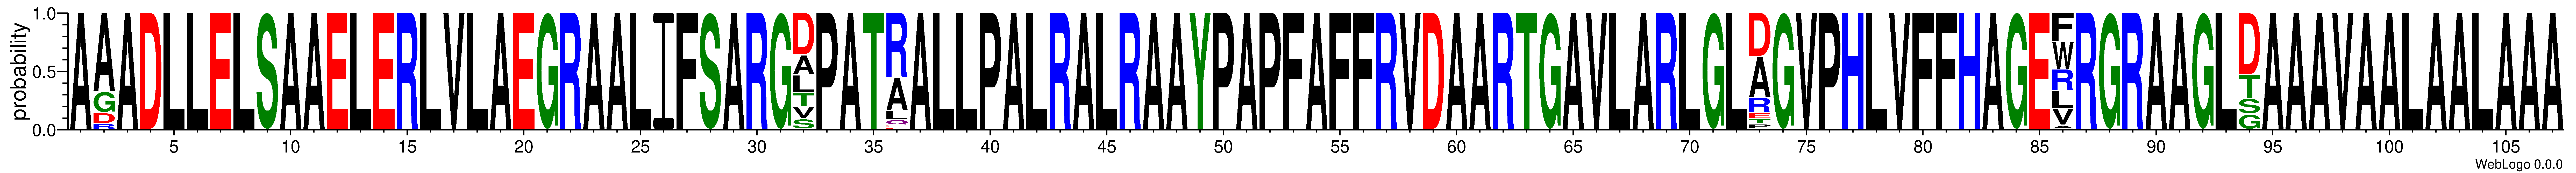

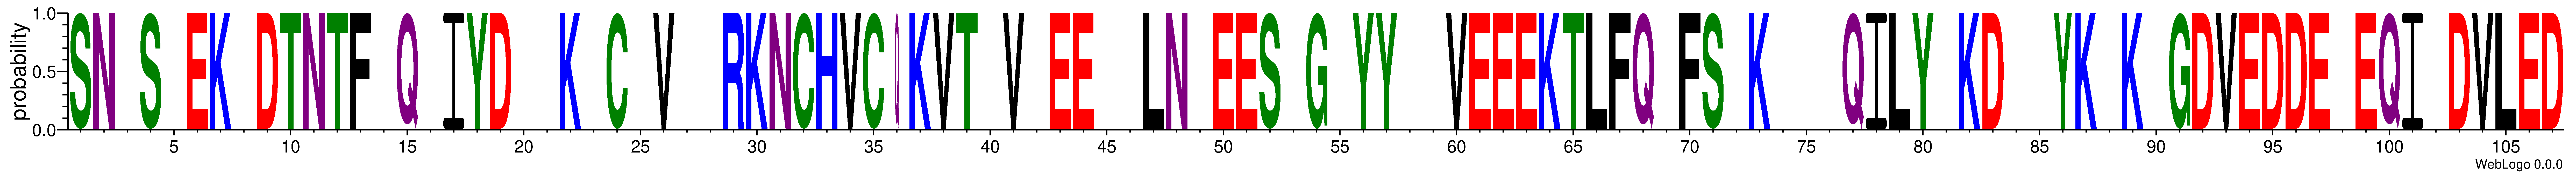

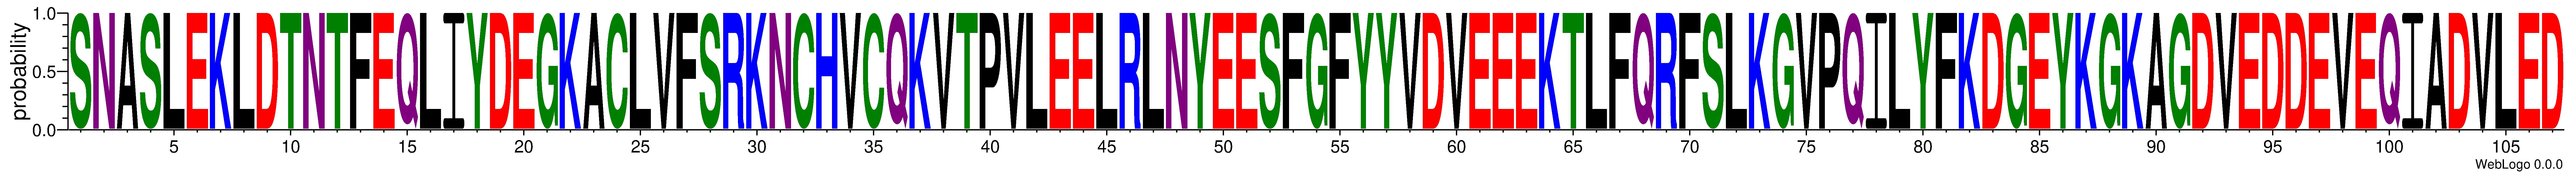

In [17]:
def remove_dups(a, b):
    seqs = []
    for seqb in b:
        lseqb = list(seqb)            
        for seqa in a:
            for i in range(len(a[0])):
                if lseqb[i] == seqa[i]:
                    lseqb[i] = ' '
            seqs.append(''.join(lseqb))
    return seqs

print("Wild type, Generated - Wild Type, Generated, Wild Type - Generated, Wild Type")
# display(
#     viz.render_weblogo([STRUCTURE_SUMMARY.sequence]),
#     viz.render_weblogo(remove_dups([STRUCTURE_SUMMARY.sequence], df["sequence"].values)),
#     viz.render_weblogo(df["sequence"].values),
#     viz.render_weblogo(remove_dups(df["sequence"].values, [STRUCTURE_SUMMARY.sequence])),
#     viz.render_weblogo([STRUCTURE_SUMMARY.sequence]),
# )

print("""
green  Polar       G,S,T,Y,C
purple Neutral     Q,N       
blue   Basic       K,R,H
red    Acidic      D,E
black  Hydrophobic A,V,L,I,P,W,F,M""")


display(
#     HTML('<b>Wild Type</b>'),
#     viz.render_weblogo([STRUCTURE_SUMMARY.sequence]),
#     HTML('<b>Generated - Wild Type</b>'),
#     viz.render_weblogo(remove_dups([STRUCTURE_SUMMARY.sequence], df["sequence"].values)),
    HTML('<b>Generated</b>'),
    viz.render_weblogo(df["sequence"].values),
    HTML('<b>Wild Type - Generated</b>'),
    viz.render_weblogo(remove_dups(df["sequence"].values, [STRUCTURE_SUMMARY.sequence])),
    HTML('<b>Wild Type</b>'),
    viz.render_weblogo([STRUCTURE_SUMMARY.sequence]),
)

In [15]:
viz.sequence_compare(STRUCTURE_SUMMARY.sequence,df["sequence"].values[0])

SNASLEKLDTNTFEQLIYDEGKACLVFSRKNCHVCQKVTPVLEELRLNYEESFGFYYVDVEEEKTLFQRFSLKGVPQILYFKDGEYKGKAGDVEDDEVEQIADVLED
|| | || ||||| | |||  | | |  ||||||||||| | ||  || ||| | ||  ||||||||| || |   |||| ||  || | ||||||| ||| |||||
AAADLLELSAAELERLVLAEGRAALIFSARGDPATRALLPALRALRAAYPAPFAFFRVDAARTGAVLARLGLDGVPHLVFFHAGEWRGRAAGLDAAAVAALAALAAA


In [16]:
find_contacts(PDB_PATH)

[(1, 38),
 (0, 3),
 (3, 56),
 (34, 75),
 (34, 75),
 (19, 83),
 (19, 83),
 (79, 87),
 (79, 87),
 (19, 83),
 (3, 56),
 (27, 34),
 (1, 38),
 (45, 54),
 (20, 53),
 (20, 53),
 (15, 80),
 (19, 83),
 (20, 53),
 (45, 54),
 (21, 81),
 (14, 20),
 (59, 66),
 (59, 66),
 (21, 81),
 (21, 81),
 (15, 80),
 (1, 42),
 (71, 76),
 (15, 80),
 (15, 80),
 (8, 65),
 (59, 74),
 (20, 53),
 (34, 75),
 (71, 76)]